In [60]:
import tensorflow as tf
print(tf.__version__)

physical_device = tf.config.experimental.list_physical_devices("GPU")
if len(physical_device) > 0:
    tf.config.experimental.set_memory_growth(physical_device[0], True)
    

2.2.0


# Saving and loading models

 ## Coding tutorials
 #### [1. Saving and loading model weights](#coding_tutorial_1)
 #### [2. Model saving criteria](#coding_tutorial_2)
 #### [3. Saving the entire model](#coding_tutorial_3)
 #### [4. Loading pre-trained Keras models](#coding_tutorial_4)
 #### [5. Tensorflow Hub modules](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Saving and loading model weights

#### Load and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. For an introduction and a download, see [this link](https://www.cs.toronto.edu/~kriz/cifar.html).

In [2]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

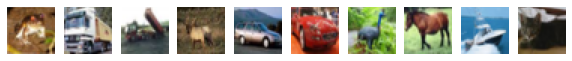

In [3]:
# Plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

#### Introduce two useful functions

In [4]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [5]:
# Introduce function that creates a new instance of a simple CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Create simple convolutional neural network classifier

In [6]:
# Create an instance of the model and show model summary
model = get_new_model()
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 8)         1160      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 7, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                12576     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 14,514
Trainable params: 14,514
Non-trainable params: 0
____________________________________________________

In [7]:
# Test accuracy of the untrained model, around 10% (random)

get_test_accuracy(model, x_test, y_test)

accuracy: 0.108


#### Train model with checkpoints

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [9]:
# Create Tensorflow checkpoint object
checkpoint_path = 'model_checkpoints/checkpoints'

checkpoints = ModelCheckpoint(filepath=checkpoint_path,
                              frequency='epoch',
                              save_weights_only=True,
                              verbose=1)

In [10]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch

model.fit(x_train, y_train, epochs=3, callbacks=[checkpoints])

Epoch 1/3
313/313 [==============================] - ETA: 0s - loss: 1.9835 - accuracy: 0.2713
Epoch 00001: saving model to model_checkpoints/checkpoints
313/313 [==============================] - 1s 3ms/step - loss: 1.9835 - accuracy: 0.2713
Epoch 2/3
289/313 [==========================>...] - ETA: 0s - loss: 1.6028 - accuracy: 0.4214
Epoch 00002: saving model to model_checkpoints/checkpoints
313/313 [==============================] - 1s 2ms/step - loss: 1.5968 - accuracy: 0.4249
Epoch 3/3
303/313 [============================>.] - ETA: 0s - loss: 1.4543 - accuracy: 0.4750
Epoch 00003: saving model to model_checkpoints/checkpoints
313/313 [==============================] - 1s 3ms/step - loss: 1.4518 - accuracy: 0.4763


In [11]:
# Have a look at what the checkpoint creates
!ls -lh model_checkpoints

total 184K
-rw-r--r-- 1 mehedi mehedi   79 জুলাই  10 10:22 checkpoint
-rw-r--r-- 1 mehedi mehedi 3.6K জুলাই  10 10:22 checkpoints.data-00000-of-00002
-rw-r--r-- 1 mehedi mehedi 171K জুলাই  10 10:22 checkpoints.data-00001-of-00002
-rw-r--r-- 1 mehedi mehedi 2.1K জুলাই  10 10:22 checkpoints.index


In [12]:
# Evaluate the performance of the trained model
get_test_accuracy(model, x_test, y_test)


accuracy: 0.472


#### Create new model, load weights

In [13]:
# Create a new instance of the (initialised) model, accuracy around 10% again

model = get_new_model()
get_test_accuracy(model, x_test, y_test)

accuracy: 0.103


In [14]:
# Load weights -- accuracy is the same as the trained model
model.load_weights(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.472


#### Clear directory

In [15]:
! rm -r model_checkpoints

***
<a id="coding_tutorial_2"></a>
## Model saving criteria

#### Create more customised checkpoint

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [32]:
# Create Tensorflow checkpoint object with epoch and batch details
checkpoint_5000_path = './model_checkpoints_5000/checkpoints_{epoch:04d}'

checkpoint_500 = ModelCheckpoint(filepath=checkpoint_5000_path,
                                 save_weights_only = True,
                                 save_freq=500,
                                 verbose=1)

In [34]:
# Create and fit model with checkpoint
model = get_new_model()
model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test),
          batch_size=10, callbacks=[checkpoint_500])

Epoch 1/3
 102/1000 [==>...........................] - ETA: 1s - loss: 2.2965 - accuracy: 0.0980
Epoch 00001: saving model to ./model_checkpoints_5000/checkpoints_0001
 604/1000 [=================>............] - ETA: 0s - loss: 2.0154 - accuracy: 0.2523
Epoch 00001: saving model to ./model_checkpoints_5000/checkpoints_0001
1000/1000 [==============================] - 2s 2ms/step - loss: 1.8922 - accuracy: 0.3016 - val_loss: 1.6709 - val_accuracy: 0.3940
Epoch 2/3
 100/1000 [==>...........................] - ETA: 1s - loss: 1.5696 - accuracy: 0.4400
Epoch 00002: saving model to ./model_checkpoints_5000/checkpoints_0002
 600/1000 [=================>............] - ETA: 0s - loss: 1.5621 - accuracy: 0.4427
Epoch 00002: saving model to ./model_checkpoints_5000/checkpoints_0002
1000/1000 [==============================] - 2s 2ms/step - loss: 1.5459 - accuracy: 0.4454 - val_loss: 1.5226 - val_accuracy: 0.4460
Epoch 3/3
 119/1000 [==>...........................] - ETA: 1s - loss: 1.4831 - ac

In [36]:
# Have a look at what the checkpoint creates
!ls -lh model_checkpoints_5000/


total 1.1M
-rw-r--r-- 1 mehedi mehedi   89 জুলাই  10 10:29 checkpoint
-rw-r--r-- 1 mehedi mehedi 3.7K জুলাই  10 10:28 checkpoints_0001.data-00000-of-00002
-rw-r--r-- 1 mehedi mehedi 3.6K জুলাই  10 10:27 checkpoints.0001.data-00000-of-00002
-rw-r--r-- 1 mehedi mehedi 171K জুলাই  10 10:28 checkpoints_0001.data-00001-of-00002
-rw-r--r-- 1 mehedi mehedi 171K জুলাই  10 10:27 checkpoints.0001.data-00001-of-00002
-rw-r--r-- 1 mehedi mehedi 2.1K জুলাই  10 10:28 checkpoints_0001.index
-rw-r--r-- 1 mehedi mehedi 2.1K জুলাই  10 10:27 checkpoints.0001.index
-rw-r--r-- 1 mehedi mehedi 3.7K জুলাই  10 10:28 checkpoints_0002.data-00000-of-00002
-rw-r--r-- 1 mehedi mehedi 3.6K জুলাই  10 10:27 checkpoints.0002.data-00000-of-00002
-rw-r--r-- 1 mehedi mehedi 171K জুলাই  10 10:28 checkpoints_0002.data-00001-of-00002
-rw-r--r-- 1 mehedi mehedi 171K জুলাই  10 10:27 checkpoints.0002.data-00001-of-00002
-rw-r--r-- 1 mehedi mehedi 2.1K জুলাই  10 10:28 checkpoints_0002.index
-rw-r--r-- 1 mehedi mehedi 2.1K জুলাই

#### Work with model saving criteria

In [37]:
# Use tiny training and test set -- will overfit!

x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [38]:
# Create a new instance of untrained model
model = get_new_model()


In [39]:
# Create Tensorflow checkpoint object which monitors the validation accuracy
checkpoint_best_path = 'model_checkpoint_best/checkpoint'

checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                                  save_weights_only=True,
                                  save_freq='epoch',
                                  monitor='val_accuracy',
                                  save_best_only=True,
                                  verbose=1)


In [40]:
# Fit the model and save only the weights with the highest validation accuracy
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test),
                    batch_size=10, callbacks=[checkpoint_best], verbose=0)



Epoch 00001: val_accuracy improved from -inf to 0.05000, saving model to model_checkpoint_best/checkpoint

Epoch 00002: val_accuracy did not improve from 0.05000

Epoch 00003: val_accuracy improved from 0.05000 to 0.07000, saving model to model_checkpoint_best/checkpoint

Epoch 00004: val_accuracy did not improve from 0.07000

Epoch 00005: val_accuracy improved from 0.07000 to 0.09000, saving model to model_checkpoint_best/checkpoint

Epoch 00006: val_accuracy did not improve from 0.09000

Epoch 00007: val_accuracy improved from 0.09000 to 0.11000, saving model to model_checkpoint_best/checkpoint

Epoch 00008: val_accuracy did not improve from 0.11000

Epoch 00009: val_accuracy improved from 0.11000 to 0.13000, saving model to model_checkpoint_best/checkpoint

Epoch 00010: val_accuracy improved from 0.13000 to 0.14000, saving model to model_checkpoint_best/checkpoint

Epoch 00011: val_accuracy did not improve from 0.14000

Epoch 00012: val_accuracy did not improve from 0.14000

Epoch 

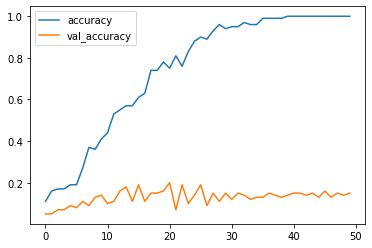

In [41]:
# Plot training and testing curves

import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

In [42]:
# Inspect the checkpoint directory
! ls -lh model_checkpoint_best/


total 184K
-rw-r--r-- 1 mehedi mehedi   77 জুলাই  10 10:35 checkpoint
-rw-r--r-- 1 mehedi mehedi 3.7K জুলাই  10 10:35 checkpoint.data-00000-of-00002
-rw-r--r-- 1 mehedi mehedi 171K জুলাই  10 10:35 checkpoint.data-00001-of-00002
-rw-r--r-- 1 mehedi mehedi 2.1K জুলাই  10 10:35 checkpoint.index


In [43]:
# Create a new model with the saved weights
new_model = get_new_model()
new_model.load_weights(checkpoint_best_path)
get_test_accuracy(new_model, x_test, y_test)

accuracy: 0.200


#### Clear directory

In [45]:
! rm -r model_checkpoints_5000 model_checkpoint_best

rm: cannot remove 'model_checkpoints_5000': No such file or directory


***
<a id="coding_tutorial_3"></a>
## Saving the entire model

#### Create checkpoint that saves whole model, not just weights

In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [47]:
# Create Tensorflow checkpoint object
checkpoint_path = 'model_checkpoints'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=False,
                             frequency='epoch',
                             verbose=1)


In [48]:
# Create and fit model with checkpoint
model = get_new_model()
model.fit(x_train, y_train, epochs=3, callbacks=[checkpoint])


Epoch 1/3
1/4 [======>.......................] - ETA: 0s - loss: 2.3094 - accuracy: 0.0938
Epoch 00001: saving model to model_checkpoints
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_checkpoints/assets
4/4 [==============================] - 0s 116ms/step - loss: 2.3018 - accuracy: 0.0800
Epoch 2/3
1/4 [======>.......................] - ETA: 0s - loss: 2.2715 - accuracy: 0.0938
Epoch 00002: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets
4/4 [==============================] - 0s 93ms/step - loss: 2.2656 - accuracy: 0.1700
Epoch 3/3
1/4 [======>.......................] - ETA: 0s - loss: 2.2299 - accuracy: 0.2188
Epoch 00003: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets
4/4 [==============================] - 0s 96ms/step - loss: 2.2518 - accuracy: 0.1900


#### Inspect what the checkpoint has created

In [49]:
# Have a look at what the checkpoint creates
!ls -lh model_checkpoints/


total 132K
drwxr-xr-x 2 mehedi mehedi 4.0K জুলাই  10 10:51 assets
-rw-r--r-- 1 mehedi mehedi 123K জুলাই  10 10:51 saved_model.pb
drwxr-xr-x 2 mehedi mehedi 4.0K জুলাই  10 10:51 variables


In [50]:
# Enter variables directory
!ls -lh model_checkpoints/variables/


total 184K
-rw-r--r-- 1 mehedi mehedi 6.3K জুলাই  10 10:51 variables.data-00000-of-00002
-rw-r--r-- 1 mehedi mehedi 171K জুলাই  10 10:51 variables.data-00001-of-00002
-rw-r--r-- 1 mehedi mehedi 2.3K জুলাই  10 10:51 variables.index


In [51]:
# Get the model's test accuracy
get_test_accuracy(model, x_test, y_test)


accuracy: 0.050


#### Create new model from scratch

In [52]:
# Delete model
del model


In [53]:
from tensorflow.keras.models import load_model

In [54]:
# Reload model from scratch

model = load_model(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.050


#### Use the .h5 format to save model

In [55]:
# Save the model in .h5 format
model.save('my_model.h5')


In [56]:
# Inspect .h5 file
!ls -lh my_model.h5


-rw-r--r-- 1 mehedi mehedi 77K জুলাই  10 10:55 my_model.h5


In [57]:
# Delete model
del model


In [58]:
# Reload model from scratch

model = load_model('my_model.h5')
get_test_accuracy(model, x_test, y_test)

accuracy: 0.050


#### Clear directory

In [59]:
! rm -r model_checkpoints
! rm my_model.h5

***
<a id="coding_tutorial_4"></a>
## Loading pre-trained Keras models

#### Import and build Keras ResNet50 model

Today we'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications. Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. If you continue using it, please cite it properly! The paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

In the coding tutorial on Coursera, this model is loaded directly from disk. On Colab, you will load the model using the Keras API.

In [61]:
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 312s 3us/step


#### Import and preprocess 3 sample images

In [64]:
# Retrieve the image files

!wget -q -O lemon.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1JSgQ9qgi9nO9t2aGEk-zA6lzYNUT9vZJ"
!wget -q -O viaduct.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1sQzMKmyCR5Tur19lP3n1IIlEMG_o6Mct"
!wget -q -O water_tower.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1cPAQD1O6mAiMbg0fmG5HIk8OuO_BSC6J"

In [68]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('lemon.jpg', target_size=(224, 224))
mango_img = load_img('mango.jpg', target_size=(224, 224))
banana_img = load_img('banana.jpg', target_size=(224, 224))

#### Use ResNet50 model to classify images

In [67]:
# Useful function: presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(model.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds

##### Image 1: lemon

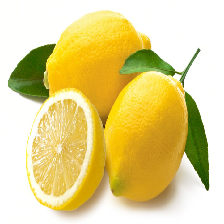

In [70]:
# Display image
lemon_img

In [71]:
# Display top 5 predictions
get_top_5_predictions(lemon_img)


,prediction,probability
1,lemon,0.996455
2,orange,0.00351864
3,jackfruit,3.6263e-06
4,strainer,2.87359e-06
5,banana,2.33061e-06


##### Image 2: viaduct

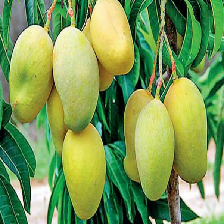

In [72]:
# Display image
mango_img


In [73]:
# Display top 5 predictions
get_top_5_predictions(mango_img)


,prediction,probability
1,banana,0.523779
2,corn,0.156205
3,ear,0.0920004
4,lemon,0.0646178
5,grocery_store,0.0147292


##### Image 3: water tower

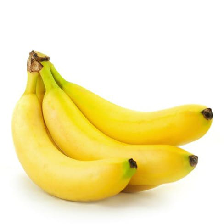

In [74]:
# Display image
banana_img


In [75]:
# Display top 5 predictions

get_top_5_predictions(banana_img)

,prediction,probability
1,banana,0.899911
2,lemon,0.0338759
3,orange,0.0173354
4,fig,0.0150827
5,zucchini,0.00342037


***
<a id="coding_tutorial_5"></a>
## Tensorflow Hub modules

#### Import and build Tensorflow Hub MobileNet v1 model

Today we'll be using Google's MobileNet v1 model, available on Tensorflow Hub. Please see the description on the [Tensorflow Hub page](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4) for details on it's architecture, how it's trained, and the reference. If you continue using it, please cite it properly! The paper it comes from is:

Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", 2017.

In the coding tutorial on Coursera, this model is loaded directly from disk. On Colab, you will load the model from TensorFlow Hub.

In [76]:
!pip install "tensorflow_hub>=0.6.0"

     |████████████████████████████████| 101 kB 174 kB/s ta 0:00:01


In [77]:
import tensorflow_hub as hub

In [79]:
# Build Google's Mobilenet v1 model

module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])

#### Use MobileNet model to classify images

In [ ]:
# Retrieve the image files

!wget -q -O lemon.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1JSgQ9qgi9nO9t2aGEk-zA6lzYNUT9vZJ"
!wget -q -O viaduct.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1sQzMKmyCR5Tur19lP3n1IIlEMG_o6Mct"
!wget -q -O water_tower.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1cPAQD1O6mAiMbg0fmG5HIk8OuO_BSC6J"

In [80]:
# Import and preprocess 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img("lemon.jpg", target_size=(160, 160))
viaduct_img = load_img("banana.jpg", target_size=(160, 160))
water_tower_img = load_img("mango.jpg", target_size=(160, 160))

In [82]:
# Read in categories text file

with open('ImageNetLabels.txt') as txt_file:
    categories = txt_file.read().splitlines()

In [83]:
# Useful function: presents top 5 predictions

import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...] / 255.0
    preds = model.predict(x)
    top_preds = pd.DataFrame(columns=['prediction'],
                             index=np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
            
    return top_preds

##### Image 1: lemon

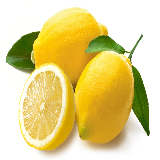

In [84]:
lemon_img

In [85]:
get_top_5_predictions(lemon_img)

,prediction
1,lemon
2,orange
3,spaghetti squash
4,banana
5,bell pepper


##### Image 2: viaduct

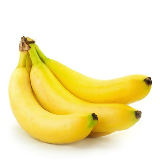

In [86]:
viaduct_img

In [87]:
get_top_5_predictions(viaduct_img)

,prediction
1,banana
2,mortar
3,bell pepper
4,lemon
5,acorn squash


##### Image 3: water tower

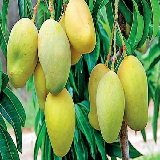

In [88]:
water_tower_img

In [89]:
get_top_5_predictions(water_tower_img)

,prediction
1,lemon
2,spaghetti squash
3,orange
4,jackfruit
5,banana
